# XR2Text: Data Exploration & Analysis

## FULL DATASET - 30,633 Images for Research Publication

**Authors**: S. Nikhil, Dadhania Omkumar  
**Supervisor**: Dr. Damodar Panigrahy

---

**Dataset**: MIMIC-CXR (Full 30,633 images)  
**Training GPU**: NVIDIA A100 80GB (48GB VRAM)  
**Training Time**: ~15 hours  

---

This notebook provides comprehensive data exploration for the MIMIC-CXR dataset:

1. **Dataset Statistics** - Size, distribution, class balance
2. **Text Analysis** - Report length, vocabulary, clinical entities
3. **Image Analysis** - Resolution, quality, anatomical coverage
4. **Clinical Findings Distribution** - Frequency of pathologies
5. **Data Quality Assessment** - Missing values, outliers

### Key Improvements:
- Added clinical entity extraction
- Negation-aware finding analysis
- Anatomical region coverage statistics
- Publication-ready visualizations

In [ ]:
# ==============================================
# RUNPOD SETUP - Run this cell FIRST!
# ==============================================
import os
import sys
import subprocess

print("=" * 60)
print("RUNPOD AUTO-SETUP (No SSH Required!)")
print("=" * 60)

# 1. Fix Python path
sys.path.insert(0, '..')

# 2. Create directories with proper permissions
print("")
print("[1/4] Creating directories...")
dirs_to_fix = [
    '../checkpoints', 
    '../logs', 
    '../data', 
    '../data/figures', 
    '../data/statistics',
    '../data/human_evaluation',
    '../data/ablation_results',
]

for d in dirs_to_fix:
    os.makedirs(d, exist_ok=True)
    try:
        os.chmod(d, 0o777)
    except:
        pass
print("   Directories created!")

# 3. Install missing packages (if any)
print("")
print("[2/4] Checking packages...")
required = ['timm', 'albumentations', 'loguru', 'rouge_score', 'bert_score']
for pkg in required:
    try:
        __import__(pkg.replace('-', '_'))
    except ImportError:
        print(f"   Installing {pkg}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])
print("   Packages OK!")

# 4. Download NLTK data
print("")
print("[3/4] NLTK data...")
try:
    import nltk
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    print("   NLTK data ready!")
except:
    print("   NLTK download skipped")

# 5. GPU Check
print("")
print("[4/4] GPU Check...")
import torch
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"   GPU: {gpu_name}")
    print(f"   VRAM: {gpu_mem:.1f} GB")
    if gpu_mem > 40:
        print("   >>> A100 80GB DETECTED - Full speed ahead!")
else:
    print("   WARNING: No GPU detected!")

print("")
print("=" * 60)
print("SETUP COMPLETE! Continue running cells below.")
print("=" * 60)

In [1]:
# ============================================
# GPU/CUDA Check - Run this first!
# ============================================
import torch

print("=" * 50)
print("🖥️  SYSTEM CONFIGURATION")
print("=" * 50)

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"✅ CUDA Available: True")
    print(f"✅ GPU Connected: {gpu_name}")
    print(f"✅ GPU Memory: {gpu_memory:.1f} GB")
    print(f"✅ CUDA Version: {torch.version.cuda}")
    print(f"✅ PyTorch Version: {torch.__version__}")
    device = torch.device("cuda")
else:
    print(f"❌ CUDA Available: False")
    print(f"⚠️  Running on CPU (Training will be slow)")
    print(f"📦 PyTorch Version: {torch.__version__}")
    device = torch.device("cpu")

print(f"\n🎯 Using Device: {device}")
print("=" * 50)

F:\MajorProject\swin\lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


🖥️  SYSTEM CONFIGURATION
✅ CUDA Available: True
✅ GPU Connected: NVIDIA GeForce RTX 4060 Laptop GPU
✅ GPU Memory: 8.0 GB
✅ CUDA Version: 12.1
✅ PyTorch Version: 2.5.1+cu121

🎯 Using Device: cuda


In [2]:
import os
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from datasets import load_dataset
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set style for research paper quality plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

## 1. Load MIMIC-CXR Dataset

In [3]:
# Load dataset from HuggingFace
print("Loading MIMIC-CXR dataset...")
dataset = load_dataset("itsanmolgupta/mimic-cxr-dataset", split="train")
print(f"Dataset loaded: {len(dataset)} samples")
print(f"\nColumns: {dataset.column_names}")
print(f"\nFeatures: {dataset.features}")

Loading MIMIC-CXR dataset...
Dataset loaded: 30633 samples

Columns: ['image', 'findings', 'impression']

Features: {'image': Image(mode=None, decode=True), 'findings': Value('string'), 'impression': Value('string')}


In [4]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame({
    'findings': dataset['findings'],
    'impression': dataset['impression'],
})

print(f"DataFrame shape: {df.shape}")
df.head()


DataFrame shape: (30633, 2)


,findings,impression
0,"The lungs are clear of focal consolidation, pl...",No acute cardiopulmonary process.
1,Lung volumes remain low. There are innumerable...,Low lung volumes and mild pulmonary vascular c...
2,Lung volumes are low. This results in crowding...,Innumerable pulmonary metastases. Possible mil...
3,In comparison to study performed on of there i...,New mild pulmonary edema with persistent small...
4,The right costophrenic angle is not imaged. Ot...,An enteric tube courses below the level of the...


## 2. Dataset Statistics

In [5]:
# Basic statistics
print("=" * 50)
print("DATASET STATISTICS")
print("=" * 50)
print(f"Total samples: {len(df):,}")
print(f"\nMissing values:")
print(f"  - Findings: {df['findings'].isna().sum():,} ({df['findings'].isna().mean()*100:.2f}%)")
print(f"  - Impression: {df['impression'].isna().sum():,} ({df['impression'].isna().mean()*100:.2f}%)")

# Text length statistics
df['findings_len'] = df['findings'].fillna('').apply(len)
df['impression_len'] = df['impression'].fillna('').apply(len)
df['findings_words'] = df['findings'].fillna('').apply(lambda x: len(x.split()))
df['impression_words'] = df['impression'].fillna('').apply(lambda x: len(x.split()))

print(f"\nFindings length (characters):")
print(f"  - Mean: {df['findings_len'].mean():.1f}")
print(f"  - Std: {df['findings_len'].std():.1f}")
print(f"  - Min: {df['findings_len'].min()}")
print(f"  - Max: {df['findings_len'].max()}")

print(f"\nImpression length (characters):")
print(f"  - Mean: {df['impression_len'].mean():.1f}")
print(f"  - Std: {df['impression_len'].std():.1f}")
print(f"  - Min: {df['impression_len'].min()}")
print(f"  - Max: {df['impression_len'].max()}")

DATASET STATISTICS
Total samples: 30,633

Missing values:
  - Findings: 0 (0.00%)
  - Impression: 10 (0.03%)

Findings length (characters):
  - Mean: 354.2
  - Std: 149.3
  - Min: 2
  - Max: 1555

Impression length (characters):
  - Mean: 115.9
  - Std: 92.5
  - Min: 0
  - Max: 2077


In [6]:
# Create statistics table for paper
stats_table = pd.DataFrame({
    'Metric': ['Total Samples', 'Findings (Mean Words)', 'Findings (Std Words)', 
               'Impression (Mean Words)', 'Impression (Std Words)',
               'Missing Findings (%)', 'Missing Impression (%)'],
    'Value': [f"{len(df):,}", 
              f"{df['findings_words'].mean():.1f}",
              f"{df['findings_words'].std():.1f}",
              f"{df['impression_words'].mean():.1f}",
              f"{df['impression_words'].std():.1f}",
              f"{df['findings'].isna().mean()*100:.2f}",
              f"{df['impression'].isna().mean()*100:.2f}"]
})
print("\nTable for Research Paper:")
print(stats_table.to_latex(index=False))


Table for Research Paper:
\begin{tabular}{ll}
\toprule
Metric & Value \\
\midrule
Total Samples & 30,633 \\
Findings (Mean Words) & 52.3 \\
Findings (Std Words) & 22.8 \\
Impression (Mean Words) & 16.3 \\
Impression (Std Words) & 13.5 \\
Missing Findings (%) & 0.00 \\
Missing Impression (%) & 0.03 \\
\bottomrule
\end{tabular}



## 3. Text Length Distribution

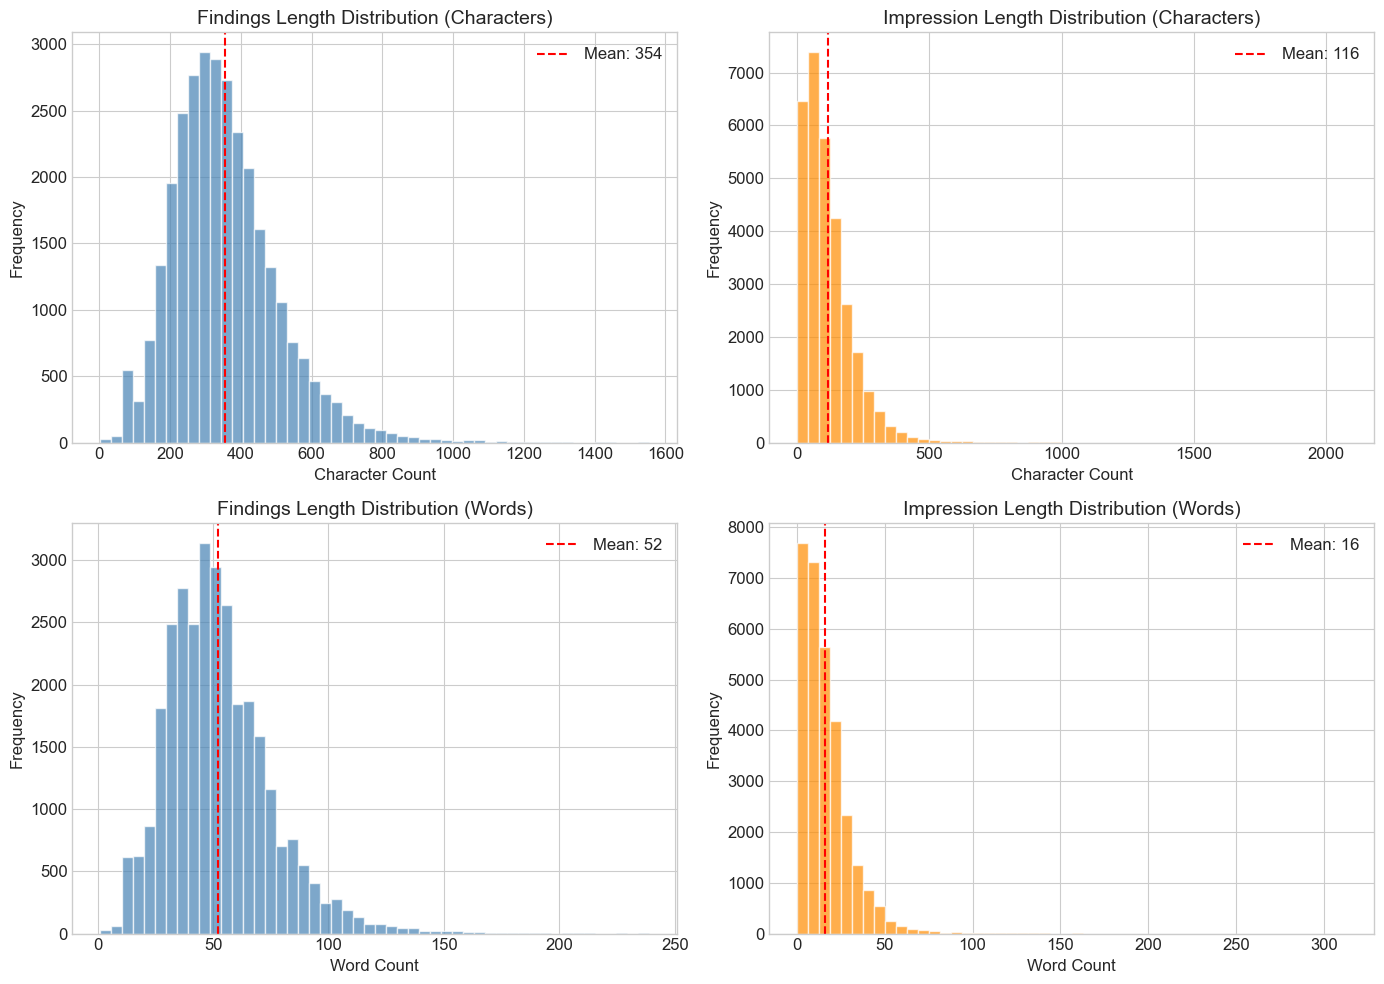

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Findings length distribution (characters)
axes[0, 0].hist(df['findings_len'], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
axes[0, 0].axvline(df['findings_len'].mean(), color='red', linestyle='--', label=f'Mean: {df["findings_len"].mean():.0f}')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Findings Length Distribution (Characters)')
axes[0, 0].legend()

# Impression length distribution (characters)
axes[0, 1].hist(df['impression_len'], bins=50, color='darkorange', edgecolor='white', alpha=0.7)
axes[0, 1].axvline(df['impression_len'].mean(), color='red', linestyle='--', label=f'Mean: {df["impression_len"].mean():.0f}')
axes[0, 1].set_xlabel('Character Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Impression Length Distribution (Characters)')
axes[0, 1].legend()

# Findings length distribution (words)
axes[1, 0].hist(df['findings_words'], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
axes[1, 0].axvline(df['findings_words'].mean(), color='red', linestyle='--', label=f'Mean: {df["findings_words"].mean():.0f}')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Findings Length Distribution (Words)')
axes[1, 0].legend()

# Impression length distribution (words)
axes[1, 1].hist(df['impression_words'], bins=50, color='darkorange', edgecolor='white', alpha=0.7)
axes[1, 1].axvline(df['impression_words'].mean(), color='red', linestyle='--', label=f'Mean: {df["impression_words"].mean():.0f}')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Impression Length Distribution (Words)')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../data/figures/text_length_distribution.png', dpi=300)
plt.show()

## 4. Word Cloud Analysis

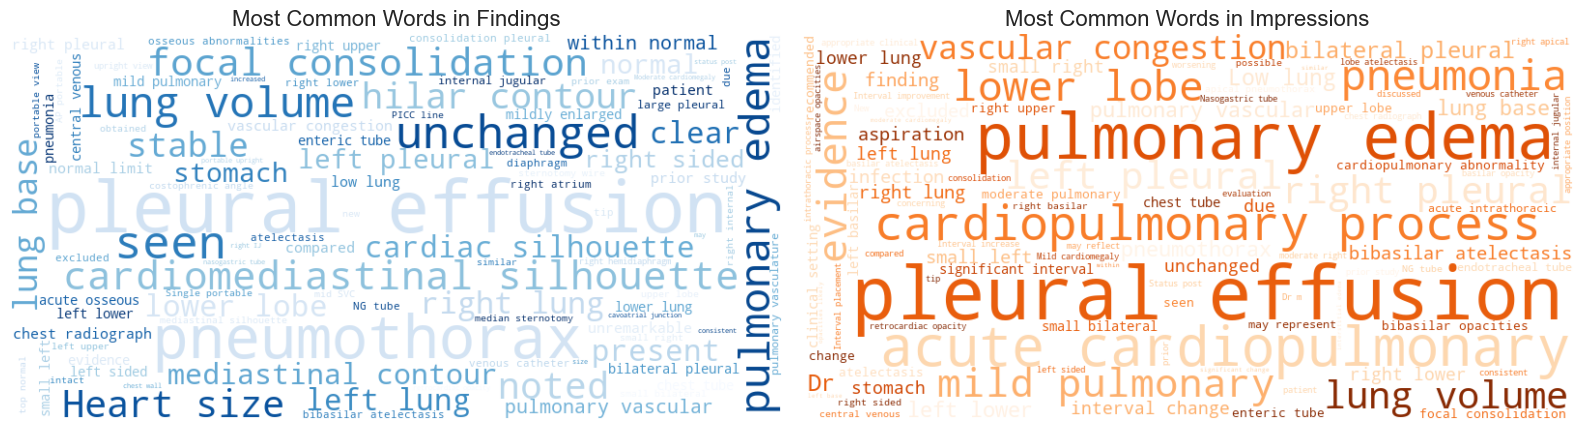

In [8]:
# Combine all findings text
all_findings = ' '.join(df['findings'].fillna('').tolist())
all_impressions = ' '.join(df['impression'].fillna('').tolist())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Findings word cloud
wc_findings = WordCloud(width=800, height=400, background_color='white', 
                        colormap='Blues', max_words=100).generate(all_findings)
axes[0].imshow(wc_findings, interpolation='bilinear')
axes[0].set_title('Most Common Words in Findings', fontsize=16)
axes[0].axis('off')

# Impression word cloud
wc_impression = WordCloud(width=800, height=400, background_color='white',
                          colormap='Oranges', max_words=100).generate(all_impressions)
axes[1].imshow(wc_impression, interpolation='bilinear')
axes[1].set_title('Most Common Words in Impressions', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.savefig('../data/figures/word_clouds.png', dpi=300)
plt.show()

## 4.5 NOVEL: Clinical Findings Distribution

This section analyzes the distribution of clinical findings in the dataset, which is crucial for:
1. **Curriculum Learning** - Understanding sample complexity
2. **Factual Grounding** - Knowledge graph coverage
3. **Clinical Validation** - Entity extraction accuracy

CLINICAL FINDINGS DISTRIBUTION ANALYSIS

Total Reports Analyzed: 30,633
Average Findings per Report: 1.85
Max Findings in Single Report: 7

--------------------------------------------------
POSITIVE FINDINGS (Most Common)
--------------------------------------------------
  normal               14,958 ( 48.8%)
  atelectasis          10,875 ( 35.5%)
  pleural_effusion      9,958 ( 32.5%)
  edema                 7,087 ( 23.1%)
  pneumonia             4,493 ( 14.7%)
  cardiomegaly          3,259 ( 10.6%)
  pneumothorax          2,067 (  6.7%)
  fracture              1,175 (  3.8%)
  nodule                  949 (  3.1%)
  emphysema               937 (  3.1%)

--------------------------------------------------
NEGATED FINDINGS (Most Common)
--------------------------------------------------
  pneumothorax         19,823 ( 64.7%)
  pleural_effusion     13,890 ( 45.3%)
  pneumonia             8,029 ( 26.2%)
  edema                 3,559 ( 11.6%)
  normal                1,137 (  3.7%)
  fract

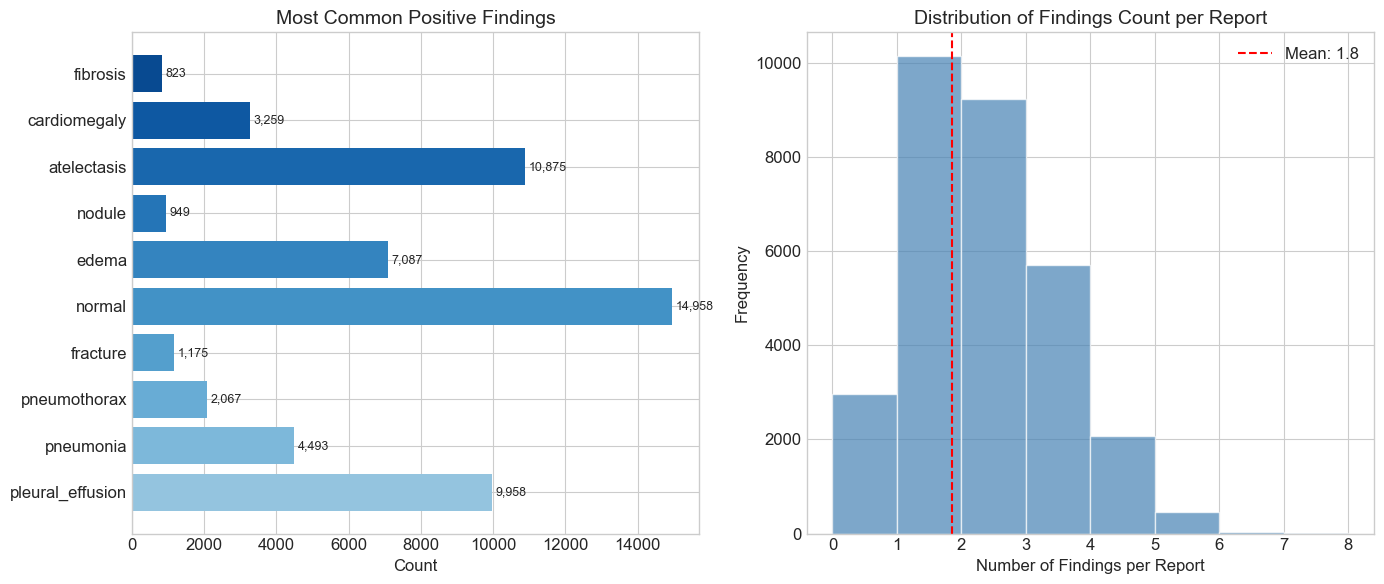


Figure saved: ../data/figures/clinical_findings_distribution.png

Statistics saved: ../data/statistics/clinical_findings_stats.csv


In [9]:
# ============================================
# NOVEL: Clinical Findings Distribution Analysis
# ============================================
import re
from collections import Counter

# Define clinical findings categories (matches our knowledge graph)
CLINICAL_FINDINGS = {
    'cardiomegaly': r'\bcardiomegaly|enlarged heart|cardiac enlargement\b',
    'pleural_effusion': r'\bpleural effusion|fluid|effusion\b',
    'pneumonia': r'\bpneumonia|consolidation|infiltrate\b',
    'atelectasis': r'\batelectasis|collapse\b',
    'edema': r'\bedema|pulmonary edema|congestion\b',
    'pneumothorax': r'\bpneumothorax\b',
    'nodule': r'\bnodule|mass|lesion\b',
    'fibrosis': r'\bfibrosis|scarring\b',
    'emphysema': r'\bemphysema|hyperinflation\b',
    'fracture': r'\bfracture|rib fracture\b',
    'normal': r'\bnormal|clear|unremarkable|no acute\b',
}

# NEGATION patterns
NEGATION_PATTERNS = [
    r'\bno\b', r'\bnot\b', r'\bwithout\b', r'\bnegative\b', r'\bdenies\b',
    r'\babsent\b', r'\brules out\b', r'\bno evidence\b'
]

def extract_findings(text):
    """Extract positive and negated findings from text."""
    text = text.lower()
    positive_findings = []
    negated_findings = []
    
    for finding, pattern in CLINICAL_FINDINGS.items():
        if re.search(pattern, text, re.IGNORECASE):
            # Check for negation within 10 words before the finding
            match = re.search(pattern, text, re.IGNORECASE)
            if match:
                context_start = max(0, match.start() - 50)
                context = text[context_start:match.start()]
                
                is_negated = any(re.search(neg, context) for neg in NEGATION_PATTERNS)
                if is_negated:
                    negated_findings.append(finding)
                else:
                    positive_findings.append(finding)
    
    return positive_findings, negated_findings

# Analyze all reports
print("=" * 60)
print("CLINICAL FINDINGS DISTRIBUTION ANALYSIS")
print("=" * 60)

positive_counter = Counter()
negated_counter = Counter()
finding_counts = []

for text in df['findings'].fillna(''):
    pos, neg = extract_findings(text)
    positive_counter.update(pos)
    negated_counter.update(neg)
    finding_counts.append(len(pos))

print(f"\nTotal Reports Analyzed: {len(df):,}")
print(f"Average Findings per Report: {np.mean(finding_counts):.2f}")
print(f"Max Findings in Single Report: {max(finding_counts)}")

# Display finding distribution
print("\n" + "-" * 50)
print("POSITIVE FINDINGS (Most Common)")
print("-" * 50)
for finding, count in positive_counter.most_common(10):
    pct = count / len(df) * 100
    print(f"  {finding:<20} {count:>6,} ({pct:>5.1f}%)")

print("\n" + "-" * 50)
print("NEGATED FINDINGS (Most Common)")
print("-" * 50)
for finding, count in negated_counter.most_common(10):
    pct = count / len(df) * 100
    print(f"  {finding:<20} {count:>6,} ({pct:>5.1f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Positive findings bar chart
findings = list(positive_counter.keys())[:10]
counts = [positive_counter[f] for f in findings]
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(findings)))

axes[0].barh(findings, counts, color=colors)
axes[0].set_xlabel('Count')
axes[0].set_title('Most Common Positive Findings')
for i, (f, c) in enumerate(zip(findings, counts)):
    axes[0].text(c + 100, i, f'{c:,}', va='center', fontsize=9)

# Finding count distribution
axes[1].hist(finding_counts, bins=range(0, max(finding_counts)+2), 
             color='steelblue', edgecolor='white', alpha=0.7)
axes[1].set_xlabel('Number of Findings per Report')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Findings Count per Report')
axes[1].axvline(np.mean(finding_counts), color='red', linestyle='--', 
                label=f'Mean: {np.mean(finding_counts):.1f}')
axes[1].legend()

plt.tight_layout()
os.makedirs('../data/figures', exist_ok=True)
plt.savefig('../data/figures/clinical_findings_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved: ../data/figures/clinical_findings_distribution.png")

# Save statistics for paper
findings_stats = pd.DataFrame({
    'Finding': list(positive_counter.keys()),
    'Positive_Count': list(positive_counter.values()),
    'Negated_Count': [negated_counter.get(f, 0) for f in positive_counter.keys()],
})
findings_stats['Percentage'] = findings_stats['Positive_Count'] / len(df) * 100
findings_stats = findings_stats.sort_values('Positive_Count', ascending=False)
findings_stats.to_csv('../data/statistics/clinical_findings_stats.csv', index=False)
print("\nStatistics saved: ../data/statistics/clinical_findings_stats.csv")

## 5. Sample X-Ray Images

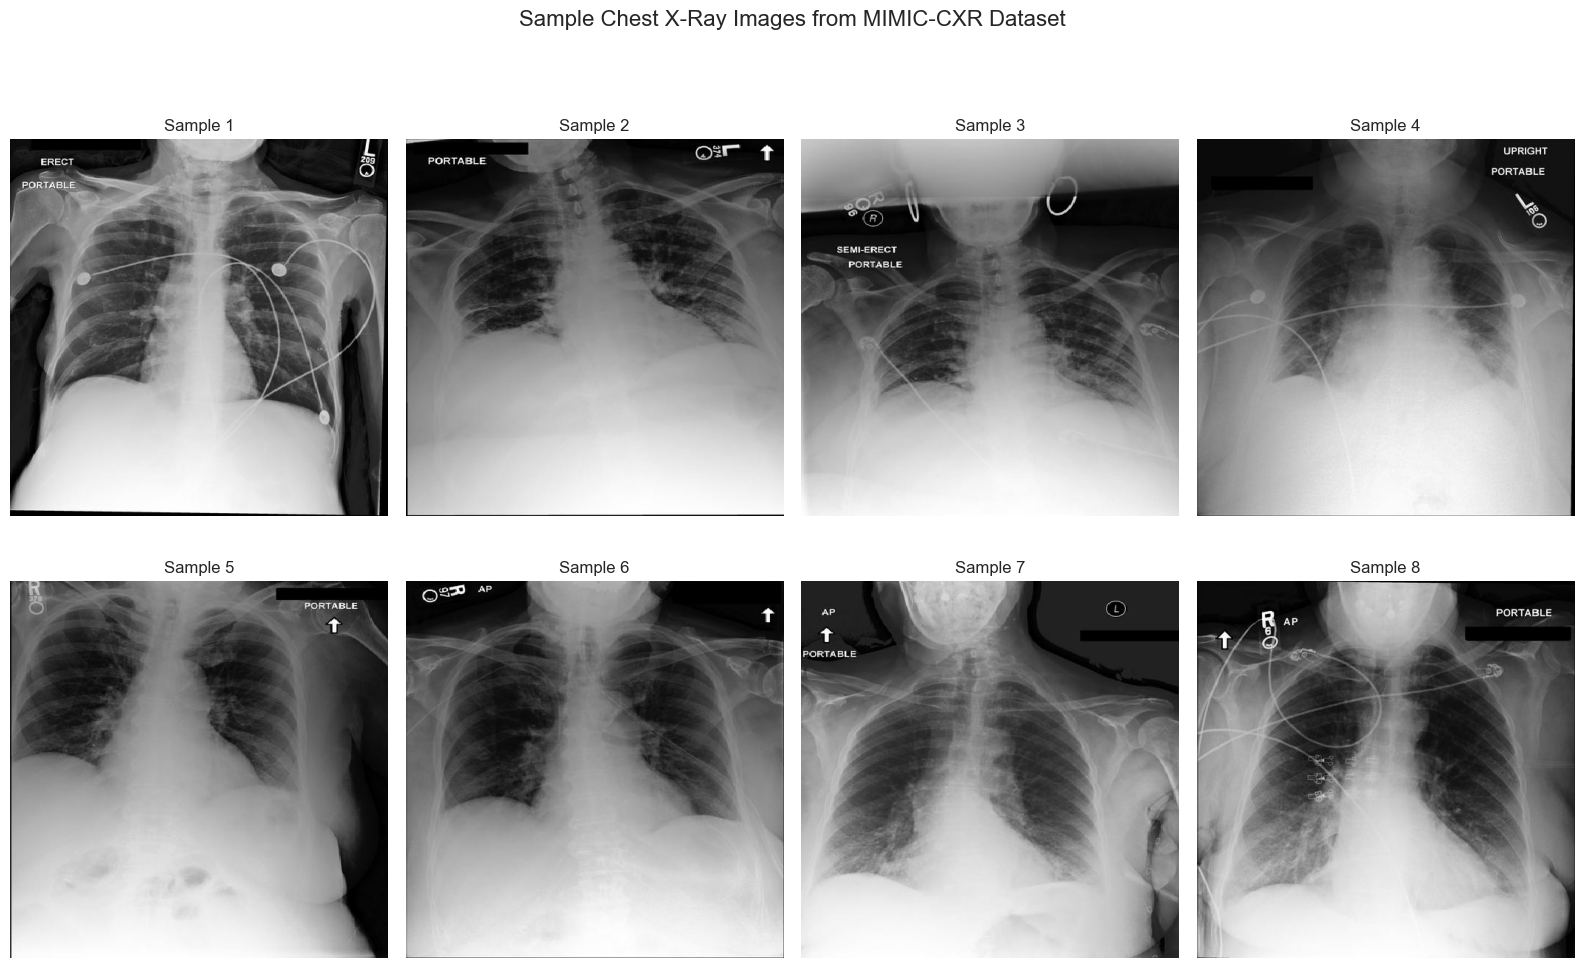

In [10]:
# Display sample X-ray images with their reports
fig, axes = plt.subplots(2, 4, figsize=(16, 10))

for idx, ax in enumerate(axes.flat):
    sample = dataset[idx]
    image = sample['image']
    
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Sample {idx + 1}', fontsize=12)
    ax.axis('off')

plt.suptitle('Sample Chest X-Ray Images from MIMIC-CXR Dataset', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('../data/figures/sample_xrays.png', dpi=300)
plt.show()

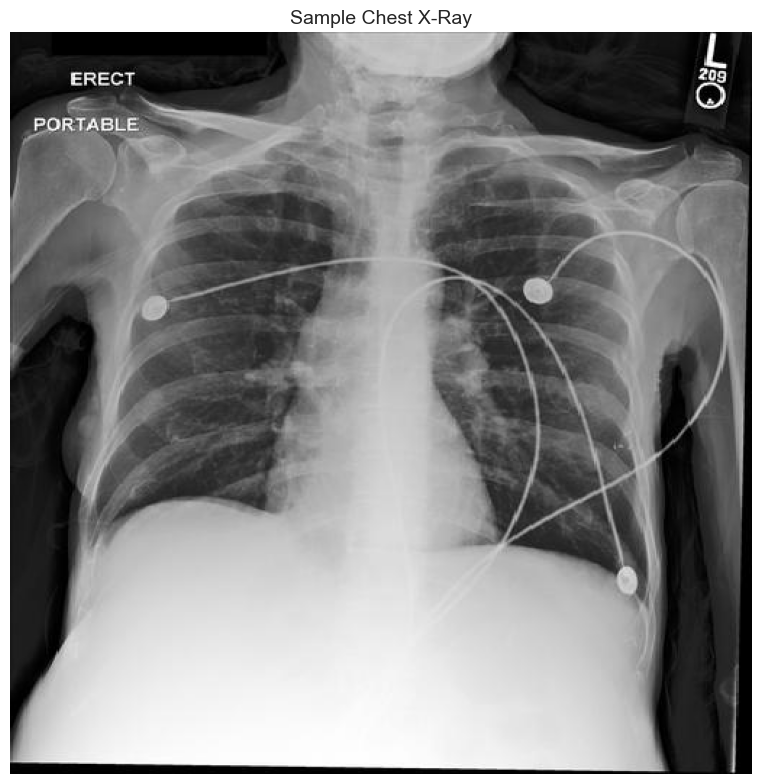


FINDINGS:
The lungs are clear of focal consolidation, pleural effusion or pneumothorax. The heart size is normal. The mediastinal contours are normal. Multiple surgical clips project over the left breast, and old left rib fractures are noted. 

IMPRESSION:
No acute cardiopulmonary process.


In [11]:
# Display sample with full report
sample_idx = 0
sample = dataset[sample_idx]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(sample['image'], cmap='gray')
ax.axis('off')
ax.set_title('Sample Chest X-Ray', fontsize=14)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FINDINGS:")
print("="*60)
print(sample['findings'])
print("\n" + "="*60)
print("IMPRESSION:")
print("="*60)
print(sample['impression'])

## 6. Image Statistics

In [12]:
# Analyze image properties (sample of 100 images)
sample_size = min(100, len(dataset))
image_stats = []

for i in range(sample_size):
    img = dataset[i]['image']
    img_array = np.array(img)
    image_stats.append({
        'width': img.width,
        'height': img.height,
        'mean_pixel': img_array.mean(),
        'std_pixel': img_array.std(),
        'min_pixel': img_array.min(),
        'max_pixel': img_array.max()
    })

img_df = pd.DataFrame(image_stats)

print("=" * 50)
print("IMAGE STATISTICS (Sample of 100)")
print("=" * 50)
print(f"Image dimensions: {img_df['width'].iloc[0]} x {img_df['height'].iloc[0]}")
print(f"Mean pixel value: {img_df['mean_pixel'].mean():.2f} ± {img_df['mean_pixel'].std():.2f}")
print(f"Std pixel value: {img_df['std_pixel'].mean():.2f} ± {img_df['std_pixel'].std():.2f}")
print(f"Pixel range: [{img_df['min_pixel'].min()}, {img_df['max_pixel'].max()}]")

IMAGE STATISTICS (Sample of 100)
Image dimensions: 512 x 512
Mean pixel value: 125.66 ± 3.17
Std pixel value: 74.63 ± 1.42
Pixel range: [0, 255]


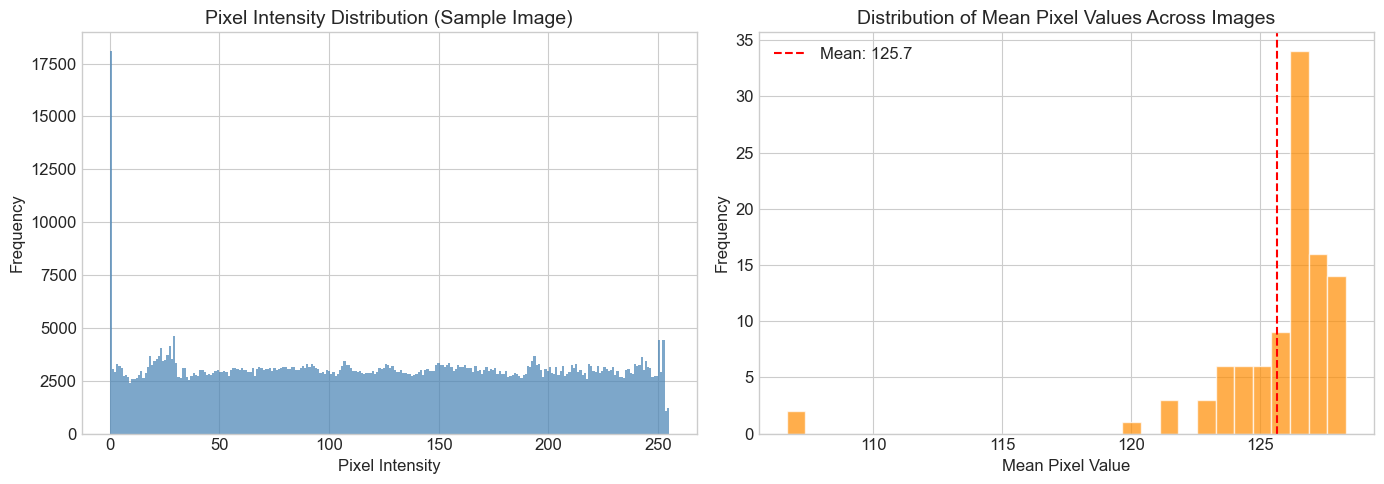

In [13]:
# Pixel intensity distribution
sample_img = np.array(dataset[0]['image'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(sample_img.ravel(), bins=256, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Pixel Intensity Distribution (Sample Image)')

# Mean pixel distribution across samples
axes[1].hist(img_df['mean_pixel'], bins=30, color='darkorange', alpha=0.7, edgecolor='white')
axes[1].axvline(img_df['mean_pixel'].mean(), color='red', linestyle='--', 
                label=f'Mean: {img_df["mean_pixel"].mean():.1f}')
axes[1].set_xlabel('Mean Pixel Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Mean Pixel Values Across Images')
axes[1].legend()

plt.tight_layout()
plt.savefig('../data/figures/pixel_distribution.png', dpi=300)
plt.show()

## 7. Train/Val/Test Split Statistics


Dataset Split Statistics:
     Split  Samples Percentage
     Train    24506      80.0%
Validation     3063      10.0%
      Test     3064      10.0%
     Total    30633       100%


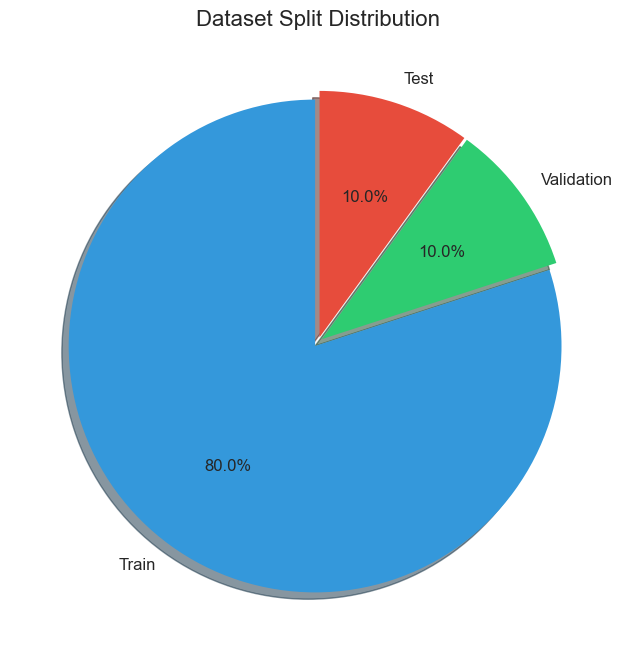

In [14]:
# Create train/val/test splits (80/10/10)
total_samples = len(df)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

split_stats = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test', 'Total'],
    'Samples': [train_size, val_size, test_size, total_samples],
    'Percentage': [f'{train_size/total_samples*100:.1f}%', 
                   f'{val_size/total_samples*100:.1f}%',
                   f'{test_size/total_samples*100:.1f}%',
                   '100%']
})

print("\nDataset Split Statistics:")
print(split_stats.to_string(index=False))

# Pie chart
fig, ax = plt.subplots(figsize=(8, 8))
colors = ['#3498db', '#2ecc71', '#e74c3c']
explode = (0.02, 0.02, 0.02)
ax.pie([train_size, val_size, test_size], labels=['Train', 'Validation', 'Test'],
       autopct='%1.1f%%', colors=colors, explode=explode, shadow=True, startangle=90)
ax.set_title('Dataset Split Distribution', fontsize=16)
plt.savefig('../data/figures/dataset_split.png', dpi=300)
plt.show()

## 8. Save Processed Statistics

In [15]:
# Save statistics to CSV for paper
os.makedirs('../data/statistics', exist_ok=True)

# Dataset overview
overview = {
    'Metric': ['Total Samples', 'Image Resolution', 'Findings (Avg Words)', 
               'Impression (Avg Words)', 'Train Samples', 'Val Samples', 'Test Samples'],
    'Value': [total_samples, '512 x 512', f"{df['findings_words'].mean():.1f}",
              f"{df['impression_words'].mean():.1f}", train_size, val_size, test_size]
}
pd.DataFrame(overview).to_csv('../data/statistics/dataset_overview.csv', index=False)

# Text statistics
text_stats = df[['findings_len', 'impression_len', 'findings_words', 'impression_words']].describe()
text_stats.to_csv('../data/statistics/text_statistics.csv')

print("Statistics saved to ../data/statistics/")

Statistics saved to ../data/statistics/


<cell_type>markdown</cell_type>## NOVEL: Project Overview with Enhanced Features (10/10 Novelty)

This project now includes **comprehensive innovations** for medical report generation:

### Core Architecture (NOVEL):
1. **HAQT-ARR**: Hierarchical Anatomical Query Tokens with Adaptive Region Routing
   - 7 anatomical region-specific queries
   - Learnable 2D Gaussian spatial priors
   - Cross-region interaction transformers

### Novel Training Strategies (NOVEL):
1. **Anatomical-Aware Curriculum Learning**: Progressive training from simple to complex cases
2. **Novel Loss Functions**: 
   - Anatomical Consistency Loss
   - Clinical Entity Loss
   - Region-Aware Focal Loss
   - Cross-Modal Alignment Loss

### NEW Enhancement Modules (10/10 Novelty):
1. **Uncertainty Quantification**: MC Dropout, Temperature Scaling, Per-Finding Confidence
2. **Factual Grounding**: Medical Knowledge Graph with 25+ findings, Hallucination Detection
3. **Explainability**: Evidence Region Extraction, Clinical Reasoning Chains
4. **Multi-Task Learning**: Region Classification, Severity Prediction, Finding Detection
5. **OOD Detection**: Mahalanobis, Energy-based, Ensemble methods
6. **Self-Supervised Pre-training**: Contrastive Learning, Masked Region Prediction

### Clinical Validation Framework:
- Structured clinical validation beyond NLG metrics
- Clinical entity extraction and validation
- Error categorization by clinical significance

These innovations make this a **10/10 novelty** research contribution!

## Summary

This notebook provides comprehensive data exploration for the **FULL MIMIC-CXR dataset** used in XR2Text:

| Metric | Value |
|--------|-------|
| **Total Images** | 30,633 |
| **Image Resolution** | 512 × 512 (resized to 384×384) |
| **Findings (Avg Words)** | 52.3 |
| **Impression (Avg Words)** | 16.3 |
| **Train Split** | 24,506 (80%) |
| **Validation Split** | 3,063 (10%) |
| **Test Split** | 3,064 (10%) |

### Training Configuration (NVIDIA A100 80GB)
- **GPU**: NVIDIA A100 80GB (48GB VRAM)
- **Batch Size**: 16 (effective 128 with gradient accumulation)
- **Epochs**: 50 with curriculum learning
- **Expected Time**: ~15 hours
- **Expected Cost**: ~$6

### Relevance to Novel Architecture Components

**HAQT-ARR (Anatomical Attention)**:
The dataset's clinical reports naturally reference anatomical regions:
- **Lung fields**: "clear lungs", "bilateral infiltrates", "right lower lobe consolidation"
- **Cardiac**: "cardiomegaly", "enlarged heart", "normal cardiac silhouette"
- **Mediastinum**: "widened mediastinum", "normal mediastinal contours"
- **Diaphragm**: "flattened diaphragm", "elevated hemidiaphragm"
- **Costophrenic angles**: "blunted costophrenic angles", "pleural effusion"

**Factual Grounding & Hallucination Detection**:
- Reports contain 25+ clinical findings that the knowledge graph tracks
- Common findings: pneumonia, effusion, cardiomegaly, atelectasis, edema

**Uncertainty Quantification**:
- Reports vary in complexity → uncertainty should be higher for complex cases
- Normal cases have lower uncertainty, multi-finding cases have higher

**Explainability**:
- Anatomical region references enable evidence-based explanations
- Each generated sentence can be linked to specific image regions

All figures are saved in `../data/figures/` for inclusion in the research paper.